# 2D Bin Packing for Woodworkers*

\* or anyone who needs to optimize material usage  
  
The current price of plywood, and building supplies in general, is ridiculous.  At these prices I don't want to buy more than I need for a project.  So given a list of "parts" I need to cut for a project, how can I arrange them into patterns on sheets to achieve the fewest number of sheets?

In the optimization world, this problem is called two dimensional bin packing.  It is an NP hard problem and optimal solutions are generally not obtainable. So researchers have been developing heuristics to solve these problems for eons.  A good primer on this subject is "A Thousand Ways to Pack the Bin - A Practical Approach to Two-Dimensional Rectangle Bin Packing", Jukka Jylänki, 2010 (Reference 1).   The author documents many approaches to 2D bin packing and compares their performance.  

If you've found this page and simply want to obtain a solution to 2D sheet cutting without messing with Python, etc.  here are a couple of nice online tools:
https://www.cutlistoptimizer.com/  Feature rich. Free (limited) or \\$15-\\$25/month subscription.  Free users can do 5 calculations a day and save 5 projects.  Supporting algorithm not revealed but probably a tree search or genetic algorithm.   
https://part-placer.com/  Free. Fewer solution options and features. 

For my purposes, I will address 2DBP problems with these constraints:  
* Offline:  The size and quantity of all parts is known prior to solution.  (vs. online packing)  
* Finite containers:  The sheets (bins) I am packing have fixed width and height.  If a part cannot be placed in an exisiting bin, a new bin is added.  
* Guillotine cuts:  All panel cuts are side to side.  For many cutting tools (e.g. table saws) it is problematic to cut part way through a panel.  
* Rotation: When parts are arranged we can allow part rotation (swapping width and height) to achieve a tighter pattern. For some projects we may want the orientation of the parts to align with the sheet, e.g. due to grain orientation. So rotation is  optional in the code below.  
<img alt="Example 1" src=.\images\guillotine-French-Revolution-2017784862.jpg  width="400" height="400" style="margin:auto">  
<p style="text-align: center">  <b>Figure 1. No, Not this Kind of Guillotine</b> </p>

## Data Source and Settings
I define the path to a part_file which is a csv file with data on the sheet size and parts needed.  
A kerf allowance can be defined.  This is the amount of sheet material that is lost each time a cut is made.  
Rotation is controlled via the rotation setting. 

In [2]:
part_file = "Test_Case_Rectangular.csv"
kerf = .125  # saw blade allowance  
rotation = True   # True = rotation allowed either before or during packing.

import sys
import copy
from itertools import product, combinations
import numpy as np
import pandas as pd

## Import the Part List
I'll import the parts list and other metadata from a csv file.   This file must be composed per the requirements in the docstring below.

In [3]:
def import_parts(part_file, kerf=0):
    """Import list of parts to be packed or cut from a CSV file. (float dims)
    
    Parameters
    ----------
    part_file : string
        file name (including path if necessary) of comma separated part file. 
        First line of part_file contains a descriptive name for the test case or
        problem being solved.  Second line has the bin width and height.
        Remaining lines in file have part_ID, width, length and quantity for 
        each part definition. Part quantities must be < 100 to work with
        renumbering scheme. When quantity > 1, part ID n is exploded into
        part ID n01, n02, etc. since each row in parts must have a unique
        part ID.
    kerf : float
        optional saw blade thickness allowance. Accounts for the material 
        lost to cutting.

    Returns
    -------
    test, string
        Description of test case or problem
    bin_W, float
        width of sheet/container/bin increased by 1 kerf
    bin_L, float
        height of sheet/container/bin increased by 1 kerf
    parts, array
        part data with columns for part_ID, width, length and area


    part_file example
    -------
    Hopper & Turton Cat 1-1
    20, 25
    0, 2, 12, 1
    1, 7, 12, 1

    """
    f = open(part_file, 'r', encoding='utf-8-sig')
    x = f.readlines()
    f.close()

    test = x[0].strip()
    bin_W = float(x[1].split(',')[0]) + kerf
    bin_H = float(x[1].split(',')[1]) + kerf
    data = []
    cols = len(x[2].split(','))

    if cols == 3:
        for i in range(2, len(x)):
            xx = list(map(float, x[i].split(',')))
            data.append([int(xx[0]), xx[1], xx[2], xx[1] * xx[2]])

    else:  # cols > 3 means each row has a quantity value.
        for i in range(2, len(x)):
            xx = list(map(float, x[i].split(',')))
            qty = int(xx[3])
            if qty > 99:
                raise ValueError("Part qty > maximum of {}".format(99))
            if qty == 1:
                data.append([int(xx[0]), xx[1], xx[2], xx[1] * xx[2]])
            else:
                for i in range(qty):
                    data.append([int(100 * xx[0] + i + 1), xx[1],
                                 xx[2], xx[1] * xx[2]])

    parts = np.array(data)
    if kerf > 0:
        for part in parts:
            part[1] += kerf
            part[2] += kerf

    return test, bin_W, bin_H, parts

test_name, sht_width, sht_height, part_list = import_parts(part_file, kerf)

sht_width, sht_height

(96.125, 48.125)

Sheet dimensions have been temporarily padded with kerf allowance prior to solution. 

In [4]:
df = pd.DataFrame(part_list, columns=['ID', 'width', 'height', 'area'])
df = df.astype(dtype={'ID': np.int32, 'width': float, 'height': float,
                          'area': float})
print(df.to_string(index=False))

 ID  width  height   area
  1 20.125  48.125  960.0
201 35.125  48.125 1680.0
202 35.125  48.125 1680.0
301 10.125  48.125  480.0
302 10.125  48.125  480.0
303 10.125  48.125  480.0
  4 20.125  40.125  800.0
501 10.125  35.125  350.0
502 10.125  35.125  350.0
601 15.125  30.125  450.0
602 15.125  30.125  450.0
603 15.125  30.125  450.0
  7 40.125  20.125  800.0
801 45.125  10.125  450.0
802 45.125  10.125  450.0
901 25.125  30.125  750.0
902 25.125  30.125  750.0
903 25.125  30.125  750.0
 10 25.125  20.125  500.0


The part_list array is converted into a Pandas DataFrame to enable better display. 
When part quantity is greater than 1, that part is exploded into multiple parts with the same dimensions.  In the example above, part 2 has quantity of 2 and so it is replaced with parts 201 and 202.   A kerf allowance is also added to each parts width and height.  This will be removed before results are presented.   
## Validity Check  

In [5]:
def check_parts(parts, W, H, rot, kerf=0):
    """Check rectangular parts vs. bin size.

    Parameters
    ----------
    parts : 2D array
        Array of parts. Each row: partID, w, l, area.
    W : float
        Bin width.
    H : float
        Bin height.
    rot : boolean
        True if parts can be rotated by packing algo
    kerf : float
        optional saw blade allowance.

    """
    
    bin_diag = np.sqrt(W**2 + H**2)
    
    for part in parts:
        if rot:
            if np.sqrt((part[1]-kerf)**2 + (part[2]-kerf)**2) > bin_diag:
                raise ValueError("Part {} diagonal greater than bin diagonal!".
                                      format(int(part[0])))
            
        else:
            if (part[1] - kerf) > W or (part[2] - kerf) > H:
                raise ValueError("Part {} width or height greater than bin!".
                                      format(int(part[0])))

check_parts(part_list, sht_width, sht_height, rotation, kerf)

No errors resulted from this check so we're good to go. 

## Guillotine Algorithm
Now we are ready to apply the Guillotine heuristic.  My Python implementation is based on this description from Jylänki's paper  mentioned in the introduction: 

Pseudocode  
&ensp; Intialize new bin:  
&emsp; Set $F = {F_0 = (W, H)}$   
 Pack:  
&emsp;      for each rectangle $r = (w,h)$ in $R$  
&emsp; &emsp;          decide which free rectangle to pack $r$ into (fit rule)  
&emsp;          if $r$ doesnt fit in any free rectangle:  
&emsp; &emsp;              restart with a new bin  
&emsp;          Decide orientation for $r$ (if rotation allowed) and place it at bottom-left of $F_i$  
&emsp;          Subdivide $F_i$ into $F'$ and $F''$ (split rule)  
&emsp;          Remove $F_i$ from $F$ and add $F'$ and $F''$  to $F$  
         
I revised it a bit for clarity.  Two key choices must be made; which free rectangle the part should be placed in (the fit rule) and how to split the free rectangle after the part is placed (splt rule).  The dashed lines in the diagram below are the possible split lines after rectangle $r$ is placed. 

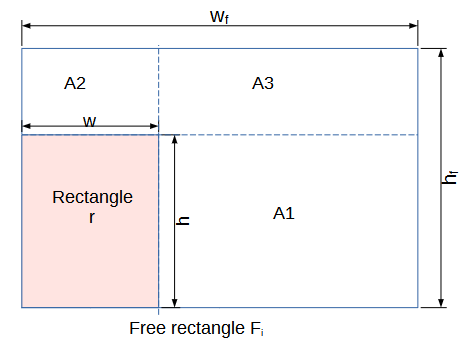


### Fit Rules    
BAF - Best area fit. Picks the free rectangle $F_i$ of smallest area in which $r$ fits.  
BLS - Best longest side fit.  Packs $r$ into the free rectangle $F_i$ with the smallest $max(w_f - w, h_f - h)$.  
&emsp; In other words, we minimize the length of the longer leftover side.  
BSS - Best short side fit. Packs $r$ into the free rectangle $F_i$ with the smallest $min(w_f - w, h_f - h)$.  
&emsp; In other words, we minimize the length of the shorter leftover side.  

### Split Rules   
MINAS - Min Area Split Rule. Join A3 with the larger of A1 and A2 to produce a single larger free rectangle  
LAS - Longer Axis Split Rule. Split horizontally if $w_f >= h_f$ and vertically otherwise.  
LLAS - Longer Leftover Axis Split Rule. Split horizontally if $w_f - w >= h_f - h$, and vertically otherwise.  
SAS -  Shorter Axis Split Rule. Split horizontally if $w_f < h_f$ and vertically otherwise.   

This is not an exhaustive list.  Reference 1 has other rules which are evaluated in their results. I chose the rules that consistently performed the best.  The combination of rules that work best depends on the specific problem being solved.  Results in Reference 1 demonstrate this fact. 

In [6]:
    fit_methods = ['BAF', 'BLS', 'BSS'] 
    split_methods = ['MINAS', 'LAS', 'LLAS', 'SAS']
    algos = list(product(fit_methods, split_methods))  # cartesian product of fit + split rule lists
    print(f'There are {len(algos)} unique ordered pairs of fit and split methods.')

There are 12 unique ordered pairs of fit and split methods.


 Since the guillotine algorithm runs fast, I will try all 12 rule combinations for each problem.  
 ## Pre-sorting  
 The order that the parts are provided to the bin packing algorithm affects performance.  Reference 1 mentions several options for this task. However, in most cases, sorting by descending area works best.   

In [7]:
    # sort part list by descending area
    parts = part_list[part_list[:, 3].argsort()[::-1]]

To simplify the subsequent code I define a Rectangle class with basic and derived properties such as area.  Most of my code is procedural because my brain works like that so apologies to object oriented adherents.  

In [8]:
class Rect():
    """Rectangle class for 2D bin packing"""
    ID = ''
    w = 0
    h = 0
    x = 0 
    y = 0
    
    def __init__(self, ID, w, h, x, y):
        """initialize a Rectangle"""
        self.ID = ID
        self.w = w
        self.h = h
        self.x = x
        self.y = y
        self.area = self.w * self.h
        self.x2 = self.x + self.w
        self.y2 = self.y + self.h
        self.ss = min(self.w, self.h)
        self.ls = max(self.w, self.h)
        self.rect = self.ID, self.w, self.h, self.x, self.y

    def __repr__(self):
        return "\nRect( ID:{}   x,y:{},{}   w,h:{},{}".format(
                self.ID, self.x, self.y, self.w, self.h)
    
    def __str__(self):
        return 'Rect(ID:' + self.ID + ', width:' + self.w + \
                ', height:' + self.h + ', x:' + self.x + ', y:' + self.y + ')'
                
    def __hash__(self):
        return hash(self.rect)
    
    def __eq__(self, other):
        if isinstance(other, Rect):
            return self.rect == other.rect
        return NotImplemented

## Supporting Functions
Several functions are used to support the guillotine heuristic.  As before, read their docstrings to learn their purpose.  

In [9]:
def check_merged(free_rects, pattern, sht_width, sht_height):
    """
    Tests merged free rectangles to insure the resultant pattern will
    still be guillotineable.

    Parameters
    ----------
    free_rects : list
        list of Rect objects .
    pattern : array
        array of packed parts each row has [id, w, l, x, y].

    Returns
    -------
    check_OK : tuple
        boolean True = pass, bin_index of failing pattern.

    """
    pattern2 = copy.deepcopy(pattern)
    check_OK = False
    # add free rects to pattern as parts
    j = 1000
    for rect in free_rects:
        pattern2 = np.append(pattern2, [[j, rect.w, rect.h, rect.area,
                                         rect.x, rect.y]], axis=0)
        j += 1
    # check this pattern for guillotine-ability
    check_OK = check_cuts([pattern2], sht_width, sht_height)
    
    return check_OK


def recursive_merge(inter, start_index = 0):
    """
    Recursive merge to remove overlapping ranges.  This is used to find possible
    guillotine cuts for a panel.

    Parameters
    ----------
    inter : list
        list of tuples defining ranges. e.g.[(0,10), (5,20), (30,40)]
    start_index : int, optional
        starting index for merging. The default is 0.

    Returns
    -------
    list
        merged intervals.

    """
    inter_ = copy.copy(inter)
    for i in range(start_index, len(inter_) - 1):
        if inter_[i][1] > inter_[i+1][0]:
            new_start = inter_[i][0]
            new_end = max(inter_[i][1], inter_[i+1][1])
            inter_[i] = (new_start, new_end)
            del inter_[i+1]
            return recursive_merge(inter_.copy(), start_index=i)

    return inter_ 


def rect_merge(free_rectangles, pattern, sht_width, sht_height):
    """
    Merge Rectangles Improvement (see Reference 1). Check all free rectangles to see if any
    neighboring free rectangles can be exactly represented as single
    larger free rectangle.

    Parameters
    ----------
    free_rectangles : list
        list of free rectangles.
    pattern : array
        array of packed parts for a bin [id, w, h, area, x, y]

    Returns
    -------
    merged_rectangles : set
        merged set of free rectangles.

    """
    merged_rectangles = set(free_rectangles)
    merged = True
    
    while merged==True:
        if len(merged_rectangles) <= 1:  # nothing to merge
            return list(merged_rectangles)
        
        # determine all the combinations of pairs in merged rectangles.   
        combos = combinations(merged_rectangles, 2)
    
        for (f1, f2) in combos:
            if f1.x==f2.x2 and f1.y==f2.y and f1.y2==f2.y2:
                # merge f1 and f2 (left edge)
                new_rect = Rect(f1.ID, f1.w + f2.w, f1.h, f2.x, f2.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break
            
            elif f1.y==f2.y2 and f1.x==f2.x and f1.x2==f2.x2:
                # merge f1 and f2 (bottom edge)
                new_rect = Rect(f1.ID, f1.w, f1.h + f2.h, f2.x, f2.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            elif f1.x2==f2.x and f1.y==f2.y and f1.y2==f2.y2:
                # merge f1 and f2 (right edge)
                new_rect = Rect(f1.ID, f1.w + f2.w, f1.h, f1.x, f1.y)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(new_rect)
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            elif f1.y2==f2.y and f1.x==f2.x and f1.x2==f2.x2:
                # merge f1 and f2 (top edge)
                merged_temp = copy.deepcopy(merged_rectangles)
                merged_temp.remove(f1)
                merged_temp.remove(f2)
                merged_temp.add(Rect(f1.ID, f1.w, f1.h + f2.h, f1.x, f1.y))
                result = check_merged(merged_temp, pattern, sht_width, sht_height)
                if result[0]:
                    merged = True
                    merged_rectangles = merged_temp
                else:
                    merged = False
                break

            else:
                merged = False

    return list(merged_rectangles)


def check_cuts(bins, sht_width, sht_height):
    """
    Check bins for guillotine cut compliance.  This is necessary since the rectangle merge improvement
    can produce free rectangles that lead to a non-guillotineable pattern.

    Parameters
    ----------
    bins : list
        list of arrays defining packed bins.
        has rows with  [part_ID, w, h, area, x1, y1]
    sht_width : int or float
        sheet width (x axis)
    sht_height : int or float
        sheet height (y axis)
        
    Returns
    -------
    all_good : boolean 
        True if all bins meet guillotine cutting requirement
    bad_bin : int
        index of first bin that fails guillotine cutting check

    """
    # all_good = True
    # bad_bin = None
    for i, binx in enumerate(bins):
        # patt = bin2patt(binx)
        patt = np.empty((0, 5))
        # array of packed parts (partID, x1, y1, x2, y2 )
        for item in binx:
            patt = np.append(patt, [[item[0], item[4], item[5],
                                       item[1] + item[4],
                                       item[2] + item[5]]], axis=0)

        extents = [0, 0, sht_width, sht_height]  # sheet dimensions
    
        status, cuts = split_pattern(patt, extents, [])
        if not status:
            # all_good = False
            # bad_bin = i
            return False, i
            
    return True, None

def split_pattern(pattern, extents, cuts):
    """
    Try to find a guillotine cut for pattern

    Parameters
    ----------
    pattern : array
        array of rectangles in a pattern. [id, x, y, x2, y2]
    extents : list
        pattern extents, [x1, y1, x2, y2], lower-left and upper-right corners
    cuts : list
        list of tuples containing axis and value for guillotine cuts

    Returns
    -------
    status : boolean
        True if pattern is guillotineable, False if not
    cuts : list
        possibly updated list of guillotine cuts

    """

    if len(pattern) == 1:  # only one rectangle in pattern
        return True, cuts
    
    # determine horiz intervals  e.g. (0,22), (15,33), ...
    horiz_intervals = []
    pattern_x = pattern[pattern[:, 1].argsort()] # pattern.sorted by x
    for i, r in enumerate(pattern_x):
        horiz_intervals.append( (r[1], r[3]) )   
    
    # merge horizontal intervals
    merged_intervals = recursive_merge(sorted(horiz_intervals))

    if len(merged_intervals) > 1:
        horiz = True
        x_cut = merged_intervals[1][0]
        cut_info = [(x_cut, extents[1]), (x_cut, extents[3])]
        cuts.append(cut_info)
 
        # create 2 sub patterns  
        pattern1 = pattern[pattern[:,1] < x_cut]
        ext1 = [extents[0], extents[1], x_cut, extents[3]]
        pattern2 = pattern[pattern[:,1] >= x_cut]
        ext2 = [x_cut, extents[1], extents[2], extents[3]]
        
        for pattern, ext in [(pattern1,ext1), (pattern2, ext2)]:
            status, cuts = split_pattern(pattern, ext, cuts) # recursive call
            if status is False:
                return False, cuts
    else:
        horiz = False  # boolean to indicate horiz split happened
            
    # determine vertical intervals  e.g. (0,22), (15,33), ...
    vert_intervals = []
    pattern_y = pattern[pattern[:, 2].argsort()] # pattern sorted by y
    for i, r in enumerate(pattern_y):
        vert_intervals.append( (r[2], r[4]) )   
    
    # merge vertical intervals   
    merged_intervals = recursive_merge(sorted(vert_intervals))
    #TODO recursive_merge not working as intended
    if len(merged_intervals) > 1:
        y_cut = merged_intervals[1][0]
        cut_info = [(extents[0], y_cut), (extents[2], y_cut)]
        cuts.append(cut_info)
        
        # create 2 new patterns  
        pattern1 = pattern[pattern[:,2] < y_cut]
        ext1 = [extents[0], extents[1], extents[2], y_cut]
        pattern2 = pattern[pattern[:,2] >= y_cut]
        ext2 = [extents[0], y_cut, extents[2], extents[3]]
        
        for pattern, ext in [(pattern1,ext1), (pattern2, ext2)]:
            status, cuts = split_pattern(pattern, ext, cuts) # recursive call
            if status is False:
                return False, cuts
            
    elif horiz==False:  # horizontal and vertical splits failed
        status = False
        
    return status, cuts

## Performance Scoring
I also developed a packing score which expresses the packing performance as a floating point number instead of just the number of sheets.  A score of 6.1 and 6.9 both mean 7 sheets are required but a score of 6.1 is better than 6.9 since it represents a better utilization of material and the lefotver material can be used for other projects. 

In [10]:
def packing_score(bins, sht_width, sht_height):
    """
    Calculate a packing score to indicate how tightly the bins are packed.
 
    Parameters
    ----------
    bins : list of 2D arrays
        Set of packed bins. Each bin is an array with rows containing 
        [part_ID, w, h, area, x, y]
    sht_width : float
        Width (horizontal) of sheet
    sht_height : float
        Height (vertical) of sheet
        
    Returns
    -------
    float
        packing score
        
    score = nbins - max(a1, a2)/sht_area
    
    a1 and a2 are the full span areas at the top or right of the bin. 
       
    This score is motivated by a desire to maximize the full span
    leftover portion on one of the bins. The leftover portion being
    more "useable" for future projects.
    Also, this metric gives a measure of how tightly the bins are packed
    instead of simply using the number of sheets required.
    
    """
    nbins = len(bins)
    best_score = nbins  # initialize
    
    for binx in bins:
    
        headRoom = sht_height - np.max(np.add(binx[:, 5],
                                              binx[:, 2]))
        # headroom is the unused portion at the top of the bin
        a1 = headRoom * sht_width
        
        elbowRoom = sht_width - np.max(np.add(binx[:, 4],
                                              binx[:, 1]))
        # elbowroom is the unused portion at the right side of the bin
        a2 = elbowRoom * sht_height
        
        score = nbins - max(a1, a2) / (sht_height * sht_width)
        
        if score < best_score:
            best_score = score
    
    return best_score

## Guillotine Solution
Finally, we are ready to solve this problem.  Seems like a lot of code for such a simple algorithm but all the variations for split and fit rules kind of blow it up. 

In [11]:
    best_score = len(parts) # initialize to a worst case value
    best_algo = ""
    for (fit, split) in algos:
        bins = [np.empty((0,6))]  # initialize first bin
        free_rects = [[Rect('f0', sht_width, sht_height, 0, 0)]]
        k = 1 # used to identify free rectangles uniquely

        for part in parts:
            p = Rect(part[0], part[1], part[2], 0, 0) # for convenience
            # initialize:
            f = None  # selected free rect
            dA = sht_height * sht_width  # init leftover area
            dls = max(sht_width, sht_height)  # init leftover long side
            dss = dls  # init leftover short side
            
            for j, _bin in enumerate(bins):
                # try part in all bins and free rects to see if any fit and 
                # identify the bin and free rect with the best fit. 
                # for this part, which free rect fits best?
                for i, fi in enumerate(free_rects[j]):
                    # does part fit in fi ?
                    if p.h <= fi.h and p.w <= fi.w:
                        w, h = p.w, p.h
                        # is part fit better in fi?
                        if fit=="BAF":  # best area fit                  
                            if fi.area - p.area < dA:
                                f = fi
                                dA = fi.area - p.area
                                bin_idx = j
                                rotated = False
                                
                        elif fit=='BLS':  # best long side fit
                            d = max(fi.w - w, fi.h - h)
                            if d < dls:
                                f = fi
                                dls = d
                                bin_idx = j
                                rotated = False
                                
                        elif fit=='BSS':  # best short side fit
                            d =  min(fi.w - w, fi.h - h)
                            if d < dss:
                                f = fi
                                dss = d
                                bin_idx = j                               
                                rotated = False
                                
                    if rotation and p.w <= fi.h and p.h <= fi.w:
                        w, h = p.h, p.w
                        if fit=="BAF":  # best area fit                  
                            if fi.area - p.area < dA:
                                f = fi
                                dA = fi.area - p.area
                                bin_idx = j
                                rotated = True
                                
                        elif fit=='BLS':  # best long side fit
                            d = max(fi.w - w, fi.h - h)
                            if d < dls:
                                f = fi
                                dls = d
                                bin_idx = j
                                rotated = True
                                
                        elif fit=='BSS':  # best short side fit
                            d =  min(fi.w - w, fi.h - h)
                            if d < dss:
                                f = fi
                                dss = d
                                bin_idx = j                            
                                rotated = True
                            
                    else: continue                    
                    
                if f == None: # part doesnt fit in any free rect in this bin
                    continue # next bin
                            
            if f == None:  # part doesnt fit in any free rect in any bins
                # open a new bin
                bins.append(np.empty((0,6)))
                bin_idx = len(bins) - 1
                
                free_rects.append([Rect('f0', sht_width, sht_height, 0, 0)])
                f = free_rects[bin_idx][0]
                
            #decide orientation for part
            if rotated:
                p.w, p.h = p.h, p.w
                
            # place part at bottom-left of f in bin[j]
            bins[bin_idx] = np.append(bins[bin_idx], [[p.ID, p.w, p.h,
                                                       (p.w-kerf) * (p.h-kerf),
                                             f.x, f.y]], axis=0)
            
            # Subdivide Fi into Fp and Fpp (split rule)
            if split=="MINAS":  # minimum area
                a1 = p.h * (f.w - p.w)
                a2 = p.w * (f.h - p.h)
                if a1 > a2: # split vert
                    fp = Rect('f' + str(k), p.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k + 1), f.w - p.w, f.h, f.x + p.w, f.y)
                else:  # split horiz
                    fp = Rect('f' + str(k), f.w - p.w, p.h, f.x + p.w, f.y)
                    fpp = Rect('f' + str(k + 1), f.w, f.h - p.h, f.x, f.y + p.h)

            elif split=='LAS':  # longer axis
                # split horizontally if f.w >= f.h and vertically otherwise
                if f.w >= f.h:  # split horizontally
                    fp = Rect('f' + str(k), f.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, p.h, f.x + p.w, f.y)
                else:  # split vertically
                    fp = Rect('f' + str(k), p.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, f.h, f.x + p.w, f.y)

            elif split=='SAS':  # shorter axis
                # split horizontally if f.w < f.h and vertically otherwise
                if f.w < f.h:  # split horizontally
                    fp = Rect('f' + str(k), f.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, p.h, f.x + p.w, f.y)
                else:  # split vertically
                    fp = Rect('f' + str(k), p.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, f.h, f.x + p.w, f.y)                    
            
            elif split=='LLAS':  # longer leftover axis
                # split horizontally if f.w - p.w >= f.h - p.h, and vertically otherwise.
                if f.w - p.w >= f.h - p.h:  # split horizontally
                    fp = Rect('f' + str(k), f.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, p.h, f.x + p.w, f.y)
                else:  # split vertically
                    fp = Rect('f' + str(k), p.w, f.h - p.h, f.x, f.y + p.h)
                    fpp = Rect('f' + str(k+1), f.w - p.w, f.h, f.x + p.w, f.y)                
                
            # Remove Fi from F and add F' and F'' 
            for n, fi in enumerate(free_rects[bin_idx]):
                if fi.ID==f.ID:
                    del free_rects[bin_idx][n]
            
            if fp.area:
                free_rects[bin_idx].append(fp)
                k += 2
            if fpp.area:
                free_rects[bin_idx].append(fpp)
                k += 2
                
            free_rects[bin_idx] = rect_merge(free_rects[bin_idx],
                                                 bins[bin_idx], sht_width, sht_height)

        score = packing_score(bins, sht_width, sht_height)
        
        if score < best_score:
            best_score = score
            best_bins = copy.deepcopy(bins)
            best_algo= fit + '-' + split
    
    print('Parts   W     L    Score   Algorithm') 
    print('{:4}{:6g}{:6g}{:8.2f}   {}'.format(len(parts), sht_width-kerf, sht_height-kerf, best_score, best_algo))

Parts   W     L    Score   Algorithm
  19    96    48    3.42   BSS-MINAS


So this project is going to need 4 sheets of material, actually 3.42, which means we will have more than half a sheet left over.  Let's see how the parts were packed by the best-short-side fit, minimum-area split, guillotine algorithm.   
## Graphical Packing Results

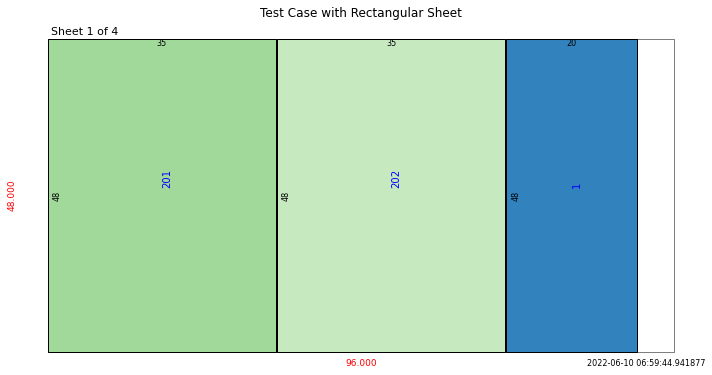

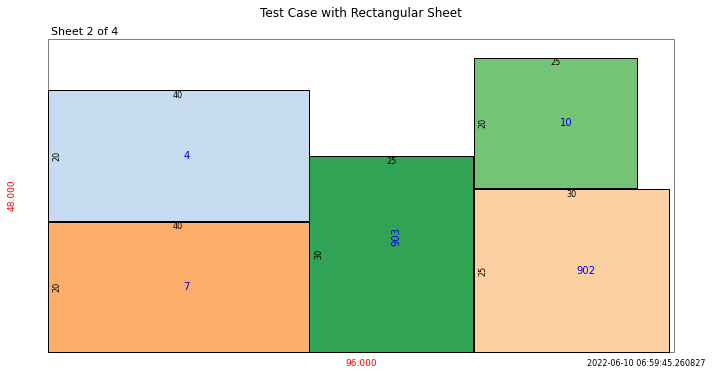

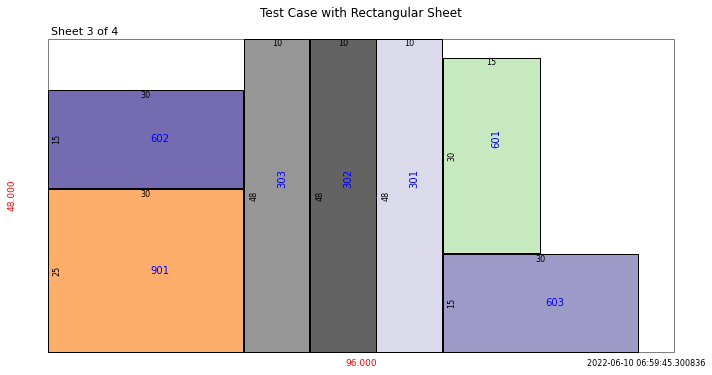

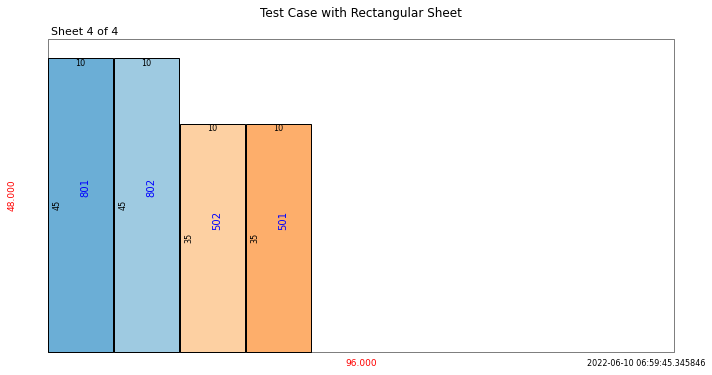

In [12]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm


def plot_sheet(Cx, Sht, score, label, plot_label, nshts=1):
    """Create a plot showing placement of rectangles packed into a sheet.

    Parameters
    ----------
    Cx : Array
        2D array with packed part information.  Each row has
        container_ID, part_ID, x1, y1, x2 and y2.
        (x1, y1 = coordinates of part lower left corner,
         x2, y2 = coordinates of upper right corner
    Sht : List
        List with [x1, y1, x2, y2] for standard sheets
    score : float  (obsolete)
        Numeric metric describing packing performance.
    label : string  (obsolete)
        Text for metric. Used in conjunction with score. Example: "Waste"
    plot_label : string
        Test case or problem description
    nshts : int
        Total number of sheets to be plotted

    Returns
    -------
    None
    """
    colors = cm.get_cmap('tab20c')

    plt.rcParams.update({'figure.max_open_warning': 0})
    cID = str(Cx[0, 0])
    fig = plt.figure(cID, figsize=(10,7.5))
    ax = plt.gca()
    # plot container boundaries
    rect = patches.Rectangle(
        (0, 0), Sht[2], Sht[3], linewidth=.5, ec='k', fc='none')
    ax.add_patch(rect)     # Add the patch to the Axes

    # add container sheet, width and height labels 
    plt.text(.05, .96, f'Sheet {Cx[0, 0]+1:.0f} of {nshts}',
             fontsize=11, color='k',
              va='bottom', ha='left', transform=ax.transAxes)
    plt.text(0, .5, f'{Sht[3]:.3f}', fontsize=9, color='r',
              va='center', ha='right', rotation='vertical',
              transform=ax.transAxes)
    plt.text(.5, 0, f'{Sht[2]:.3f}', fontsize=9, color='r',
              ha='center', va='bottom', transform=ax.transAxes )
    now = str(datetime.datetime.now())
    plt.text(1, 0, now, fontsize=8, color='k',
              va='bottom', ha='right', transform=ax.transAxes)


    for c in Cx:  # c = [cID, pID, x1, y1, x2, y2]
        x = c[2]
        y = c[3]
        width = c[4] - c[2]
        height = c[5] - c[3]

        # color = 'w'        
        # uncomment next line if you want parts to be plotted in color
        color = colors(((c[1] - 1) * .0526) % 1)

        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, ec='k', fc=color)
        ax.add_patch(rect)
        
        if c[1] % 1 > 0:
            part_label = str(c[1])
        else:
            part_label = str(int(c[1]))
        
        offset = 5
        # add part dimensions
        if width >= height:
            ax.annotate(part_label, (x + width/2, y + height/2), ha='left',
                        va='center',
                         xytext=(offset, 0), textcoords='offset points',
                         color='b')
        else:
            ax.annotate(part_label, (x + width/2, y + height/2),
                         xytext=(0, 2*offset), textcoords='offset points',
                         rotation = 'vertical', color='b')
            
        ax.annotate(f'{height:.3g}', (x, y + height/2),
                    xytext=(offset, 0), textcoords='offset points',
                    fontsize=8, va='center', rotation = 'vertical')
        ax.annotate(f'{width:.3g}', (x + width/2, y + height),
                    xytext=(0, -1.5*offset), textcoords='offset points',
                    fontsize=8, ha='center')
        
    plt.title(plot_label)
    plt.axis('scaled')
    plt.axis('off')  # hide axes
    plt.tight_layout()  # adjusts axes so that everything shows
    
    return fig


def plot_solution(patterns, sht_width, sht_height, test_name):
    """Plot solution to a 2D bin packing problem. 
    
    Each sheet is plotted in a separate figure. 
    

    Parameters
    ----------
    patterns : list
        List with arrays defining each packed sheet. Each array row has 
        part_ID, part_width, part_length, part_area, x1 and y1. Where x1, y1
        are the coordinates of the lower left corner of the part.
    sht_width : float
        Sheet width (horizontal axis)
    sht_height : float
        Sheet height (vertical axis)
    test_name : string
        Description of test case or problem solved.

    """
    figs = []
    for sht in range(len(patterns)):
        pattern = patterns[sht]
        B = np.empty((0, 6), dtype=np.int32)  # initialize plotting array
        # B - array of packed parts (binID, partID, x1, y1, x2, y2 )
        for item in pattern:
            B = np.append(B, [[sht] + [item[0], item[4], item[5],
                                       item[1] + item[4],
                                       item[2] + item[5]]], axis=0)

        S = [0, 0, sht_width, sht_height]  # sheet dimensions
        B = B.astype(float)
        fig = plot_sheet(B, S, 0, '', test_name, len(patterns))
        figs.append(fig)
        
    return figs


def clean_kerfs(bins, sht_width, sht_height, kerf):
    """
    Before plotting or printing solutions, remove kerf allowances from parts
    and sheet dimensions.

    Parameters
    ----------
    bins : list
        list of arrays representing packed bins. Parts have kerf allowances
        included.
    sht_width : float
        sheet width with kerf added.
    sht_height : float
        sheet height with kerf added.
    kerf : float
        saw blade allowance

    Returns
    -------
    bin_list : list
        list of arrays representing packed bins. Parts have kerf allowances
        removed.
    sht_width : TYPE
        sheet width without kerf
    sht_height : TYPE
        sheet height without kerf

    """
    for b in bins:
        for p in b:
            p[1] -= kerf
            p[2] -= kerf
    
    return bins, sht_width-kerf, sht_height-kerf


bin_list, sht_width, sht_height = clean_kerfs(bins, sht_width, sht_height, kerf)

figs = plot_solution(bin_list, sht_width, sht_height, test_name)

I like to print a cutting plan for patterns like this.  The next bit of code creates a pdf file from all the plots above. 

In [13]:
import matplotlib.backends.backend_pdf
# save figures to a pdf for easier printing or sharing
pdf = matplotlib.backends.backend_pdf.PdfPages(test_name + ".pdf"  )
for fig in figs:
    pdf.savefig(fig)
pdf.close()

## Conclusions
* I tried this problem with rotation disabled and got a score of 3.63, not surprising.    
* I also ran it on cutlistoptimzer.com and got a score of 3.21, their processing took longer but produced a better score.   I wrote a genetic algorithm script that uses a simlar guillotine heuristic foe 2D bin packing.  It was able to achieve an even better score of 3.1.   I'll show this in a future post.  
* I've implemented several 2D bin packing algorithms and they all work pretty well.  In my study of over 40 test cases the worst algorithm was within 1 to 2% of the best.  This difference probably isn't important for us humble woodworkers.     
